# Analysis and cleaning of The Movie Database
source: https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv

file: https://www.kaggle.com/rounakbanik/the-movies-dataset/download

In [1]:
import numpy as np
import pandas as pd
import datetime
import re
import csv
import json
import os

In [2]:
# Read in "The Movies dataset"
# if this is read in as csv, each row is a string and dictionaries are not recognized.
df=pd.read_csv("Resources/movies_metadata.csv", low_memory=False)
print(df.info())
print(df.describe())
print(df.columns)
print(df.dtypes)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

<AxesSubplot:>

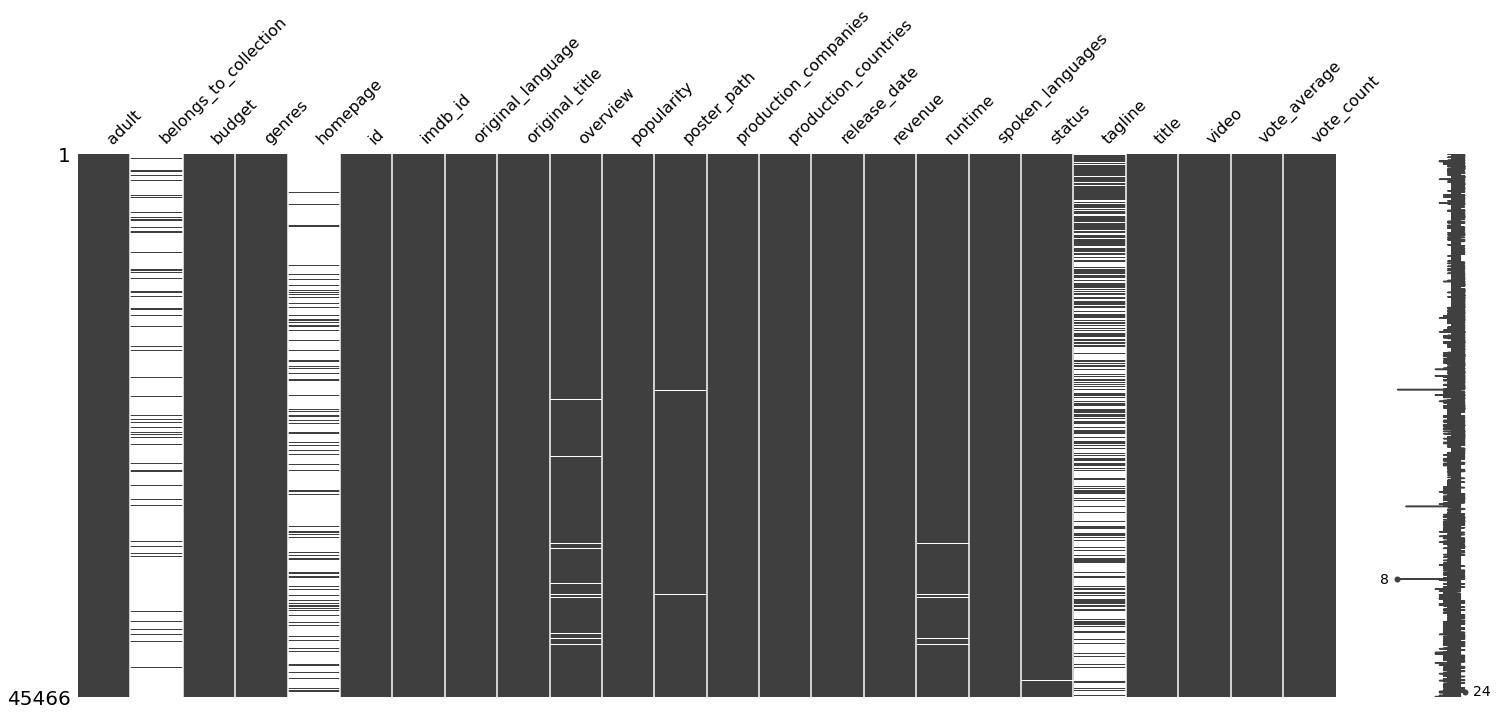

In [3]:
#Quick exploratory analysis to better understand look and feel of data
## Visualize missing values
import missingno
missingno.matrix(df)

In [4]:
#Summarize each variable
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of Results

In [3]:
# Variable Disposition:

# Drop: adult, overview, poster_path, tagline, video, original title, title, id (in favor of imdb_id)
#     candidates for NLP: overview, tagline  
# keep title initially for review purposes

# Transform: release_date -> release year
# Transform to binary: belongs_to_collection -> collection, homepage-> website, voter_average -> success (dropped,out-of-date)
# Transform to categories: original_language -> orig_lang_cd
# Transform to numeric: budget
# handling null values:
#   release_year -> drop
#   runtime -> 0
#   status -> drop - after merging with IMDB, found status is out-of-date 
# handling zero values
#   runtime: 1535 = 0, + 246 nulls converted to 0

# Keep: 
#   float: release_year, runtime, revenue, vote_count, budget, vote_average
#   categorical: success,collection, homepage, original language
#   identifiers/keys: imdb_id

# filter: release_year>1969
# keep all status to see if any "non-release" movies match imdb

# Issues: come back to. check strings for currency designation
#   budget: 76% zero
#   revenue: 81%
#   popularity: is not described

# Problems: needed to be parsed

# genres                    object - parse and transform: list of up to 3 genres per movie, genre indicator (0/1 values), # genres
# production_countries      object - result_df, cols=161
#     drop - too many to be useful in time 
# production_companies      object - p_comp_result_df,  cols= 19,179, appear to be listed in alphabetical order
#     drop - too many to be useful in time
# spoken_languages          object - 
#     drop in favor of original language

# Output datasets:

#   base dataset: clean_df to imdb_main.csv
#   genres: genre_result_df, cols=18
#     keep list of genres alphabetical order
#     keep number of genres
#     append indicator variables


## Check data types in object columns

In [4]:
cols = ["adult","belongs_to_collection","budget","genres","homepage","id","imdb_id","original_language","original_title","overview",
"popularity","poster_path","production_companies","production_countries","release_date","spoken_languages","status","tagline",
"title","video"]
print(cols)
print(type(cols))

for col in cols:
    print(f'\n datatypes in {col} column: {df[col].apply(type).value_counts()}')
    
# Results
# look into strings that should be numeric:
#   budget
# Look into the following mixed type columns
#   

['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'video']
<class 'list'>

 datatypes in adult column: <class 'str'>    45466
Name: adult, dtype: int64

 datatypes in belongs_to_collection column: <class 'float'>    40972
<class 'str'>       4494
Name: belongs_to_collection, dtype: int64

 datatypes in budget column: <class 'str'>    45466
Name: budget, dtype: int64

 datatypes in genres column: <class 'str'>    45466
Name: genres, dtype: int64

 datatypes in homepage column: <class 'float'>    37684
<class 'str'>       7782
Name: homepage, dtype: int64

 datatypes in id column: <class 'str'>    45466
Name: id, dtype: int64

 datatypes in imdb_id column: <class 'str'>      45449
<class 'float'>       17
Name: imdb_id, dtype: int64

 datatypes in original_languag

## Transform release date to year

In [5]:
# Drop movies released prior to 1970. This helps reduce some of the missing value problems.
# clean up and change release_date to datetime
# save at each change to make reverting easy
r_date=df["release_date"]
r_date.str.strip()  #remove spaces
form1=r'(^[0-9]{4})'
rel_year = r_date.str.extract(f'({form1})')  #extract just year
rel_year["release_year"]=pd.to_numeric(rel_year[0])
print(rel_year.dtypes)
rel_year.drop([0,1],axis=1,inplace=True)
print(f'null rows: {rel_year.isnull().sum()}')
# rel_year.dropna(how="any", inplace=True)
# don't drop missing yet - mark as potential drops later
print(f'number of movies: {len(rel_year)}')
print(rel_year.dtypes)

0                object
1                object
release_year    float64
dtype: object
null rows: release_year    90
dtype: int64
number of movies: 45466
release_year    float64
dtype: object


In [6]:
rel_year=rel_year[rel_year["release_year"] > 1969]
year_counts=rel_year["release_year"].value_counts()
print('year counts:')
print(year_counts)

year counts:
2014.0    1974
2015.0    1905
2013.0    1889
2012.0    1722
2011.0    1667
2016.0    1604
2009.0    1586
2010.0    1501
2008.0    1473
2007.0    1320
2006.0    1270
2005.0    1125
2004.0     992
2002.0     905
2003.0     882
2001.0     865
2000.0     789
1999.0     723
1998.0     722
1997.0     661
1996.0     633
1995.0     599
1994.0     544
2017.0     532
1993.0     489
1988.0     467
1987.0     462
1992.0     453
1989.0     439
1990.0     427
1991.0     426
1986.0     391
1972.0     381
1971.0     378
1982.0     368
1985.0     368
1984.0     362
1980.0     361
1981.0     360
1973.0     356
1983.0     353
1970.0     351
1974.0     348
1979.0     338
1977.0     334
1976.0     333
1975.0     332
1978.0     321
2018.0       5
2020.0       1
Name: release_year, dtype: int64


In [7]:
len(rel_year)

37087

In [8]:
movies_year_df = pd.concat([df, rel_year], axis=1, ignore_index=False, join="inner")
len(movies_year_df)

37087

In [9]:
print(movies_year_df.columns)
movies_year_df["release_year"].value_counts()

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'release_year'],
      dtype='object')


2014.0    1974
2015.0    1905
2013.0    1889
2012.0    1722
2011.0    1667
2016.0    1604
2009.0    1586
2010.0    1501
2008.0    1473
2007.0    1320
2006.0    1270
2005.0    1125
2004.0     992
2002.0     905
2003.0     882
2001.0     865
2000.0     789
1999.0     723
1998.0     722
1997.0     661
1996.0     633
1995.0     599
1994.0     544
2017.0     532
1993.0     489
1988.0     467
1987.0     462
1992.0     453
1989.0     439
1990.0     427
1991.0     426
1986.0     391
1972.0     381
1971.0     378
1982.0     368
1985.0     368
1984.0     362
1980.0     361
1981.0     360
1973.0     356
1983.0     353
1970.0     351
1974.0     348
1979.0     338
1977.0     334
1976.0     333
1975.0     332
1978.0     321
2018.0       5
2020.0       1
Name: release_year, dtype: int64

In [10]:
print(movies_year_df["adult"].value_counts())
movies_year_df.drop(["adult", "overview", "poster_path", "tagline", "original_title"], axis=1, inplace=True)

False    37079
True         8
Name: adult, dtype: int64


## Reduce categories of original language

In [11]:
pd.set_option("max_rows", None)
movies_year_df["original_language"].value_counts()

en    25951
fr     1945
it     1123
ja     1034
de      904
es      898
ru      663
hi      493
ko      439
zh      393
sv      320
cn      312
pt      291
fi      259
nl      234
da      206
pl      188
tr      146
no      100
fa       98
cs       94
el       88
hu       85
ta       78
th       76
he       65
sr       57
ro       54
te       45
ar       36
ml       36
hr       28
is       24
et       24
mr       24
tl       23
id       19
lv       17
sl       16
bs       13
bn       13
xx       12
ca       12
uk       10
ka       10
vi       10
ab        9
bg        9
lt        7
ur        7
sk        6
nb        6
sq        5
mk        5
sh        4
ms        4
wo        4
ky        3
bm        3
kn        3
ku        3
kk        3
eu        2
am        2
ps        2
lo        2
bo        2
af        2
iu        2
ne        2
pa        2
mn        2
rw        1
fy        1
si        1
lb        1
la        1
hy        1
gl        1
uz        1
jv        1
tg        1
sm        1
zu  

In [12]:
# Keep the top languages and set all others to "other"
orig_lang_cd=movies_year_df["original_language"]

def recode_lang(y):
    if (y in ["en", "fr", "it", "ja", "de", "es", "ru"]):
        return y
    else:
        return "other"
orig_lang_cd=orig_lang_cd.map(recode_lang)
orig_lang_cd.name="orig_lang_cd"
print(f'Original language counts: {orig_lang_cd.value_counts()}')
print(f'movie count original language: {len(orig_lang_cd)}')
print(f'movie count movies_year_df: {len(movies_year_df)}')

# Update original language - default join is outer
movies_year_df= pd.concat([movies_year_df, orig_lang_cd], axis=1, ignore_index=False, join="inner")
print(len(movies_year_df)) 

Original language counts: en       25951
other     4569
fr        1945
it        1123
ja        1034
de         904
es         898
ru         663
Name: orig_lang_cd, dtype: int64
movie count original language: 37087
movie count movies_year_df: 37087
37087


## Transform variables to 0/1

In [13]:
pd.reset_option("max_rows")
# Convert some variables to binary:
# convert belongs_to_collection, homepage and success to binary(0,1)
print(movies_year_df["belongs_to_collection"].notnull().sum())
collection=movies_year_df["belongs_to_collection"].notnull().replace([True, False], ["yes", "no"])
collection.name="collection"
print(collection.value_counts())

print(movies_year_df["homepage"].notnull().sum())
website=movies_year_df["homepage"].notnull().replace([True, False], ["yes", "no"])
website.name="website"
print(website.value_counts())

success=movies_year_df["vote_average"].apply(lambda z: "yes" if z > 5 else "no")
success.name="success"
print(success.value_counts())

clean_df = pd.concat([movies_year_df, collection, website, success], axis=1, ignore_index=False, join="inner")
clean_df.drop(["belongs_to_collection", "homepage", "vote_average"], axis=1, inplace=True)
print(clean_df.head())


3919
no     33168
yes     3919
Name: collection, dtype: int64
7680
no     29407
yes     7680
Name: website, dtype: int64
yes    27444
no      9643
Name: success, dtype: int64
     budget                                             genres     id  \
0  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4         0                     [{'id': 35, 'name': 'Comedy'}]  11862   

     imdb_id original_language popularity  \
0  tt0114709                en  21.946943   
1  tt0113497                en  17.015539   
2  tt0113228                en    11.7129   
3  tt0114885                en   3.859495   
4  tt0113041                en   8.387519   

                                production_companies  \
0     [{'name': 'Pixar Animation Studios', 'id': 3}]   
1  

## move to after merge with IMDB

## check columns of type object

In [14]:
# print(f'datatypes in budget column: {df["budget"].apply(type).value_counts()}')

In [15]:
pd.reset_option("max_rows")
clean_df_subset = clean_df[["budget", "popularity", "revenue", "runtime", "status", "video"]].copy()
# count nulls
clean_df_subset.isnull().sum()


budget          0
popularity      0
revenue         0
runtime       216
status         78
video           0
dtype: int64

In [16]:
# clean_df_subset.value_counts(dropna=False) known bug, supposed to be fixed in v 1.2 of pandas?
col_list= clean_df_subset.columns
for col in col_list:
    print(f'\n {col} {clean_df_subset[col].value_counts()}')
# drop video because mostly False


 budget 0           28815
5000000       278
10000000      255
20000000      240
15000000      222
            ...  
16700000        1
346500          1
3347850         1
837000          1
15600000        1
Name: budget, Length: 1014, dtype: int64

 popularity 1e-06       56
0.000308    42
0.0         40
0.00022     39
0.000578    38
            ..
5.819673     1
1.843332     1
0.016145     1
0.73406      1
0.60281      1
Name: popularity, Length: 35819, dtype: int64

 revenue 0.0           30058
12000000.0       13
11000000.0       13
10000000.0       12
500000.0         12
              ...  
33472850.0        1
745327.0          1
40263020.0        1
10600497.0        1
38702310.0        1
Name: revenue, Length: 6653, dtype: int64

 runtime 90.0     2287
0.0      1407
100.0    1269
95.0     1205
93.0     1044
         ... 
313.0       1
289.0       1
566.0       1
370.0       1
501.0       1
Name: runtime, Length: 338, dtype: int64

 status Released           36692
Rumored          

In [17]:
# Filter on status - don't filter yet - compare to imdb
# clean_df=clean_df[clean_df["status"].notnull()]
# print(len(clean_df))
# clean_df=clean_df[clean_df["status"].eq("Released")]
# print(len(clean_df))

# Cancelled and Planned have low vote counts, release dates 2015+, except for a few in 2012, Cancelled has release year 2003, some have runtimes and some are zero
# In Production all have zero revenue, and budget, # votes < 100, except one with 219, release_year 2009 +, mostly 2015+
# Post Production mostly missing revenue and budget, vote counts < 100, most have release dates 2014+
# Rumored mostly missing budget and revenue, low vote counts, release dates all over the place.
# Null mostly missing revenue and budget, have low vote counts, release years all over.
# Looks like status not equal to released is a pretty good indication the movie hasn't been updated with up-to-date information
# Release year is not reliable because it can be planned or expected and not actual
# 
# Decided to drop status from TMDB because the data is old and not reliable.

## come back to budget and revenue

In [18]:
clean_df_subset = clean_df[["budget", "popularity", "revenue", "runtime"]].copy()


In [19]:
# Budget: has 28,445 with value 0 out of a total 36,692 movies 76%
# Revenue: has 29,674 with value 0 out of a total 36,692 movies 81%
# Runtime: has 211 missing, 1,352 with value 0 = 4%, convert runtime missing to 0
# Popularity has no missing, 56 effectvely zero but need to find out what this is.

In [20]:
# Transform budget to numeric
clean_df["budget"] = pd.to_numeric(clean_df["budget"], errors="coerce")

In [21]:
print(clean_df.columns)
clean_df.drop(["video", "title", "release_date"], axis=1, inplace=True)
print(clean_df.columns)


Index(['budget', 'genres', 'id', 'imdb_id', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_count', 'release_year', 'orig_lang_cd', 'collection', 'website',
       'success'],
      dtype='object')
Index(['budget', 'genres', 'id', 'imdb_id', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'status', 'vote_count', 'release_year',
       'orig_lang_cd', 'collection', 'website', 'success'],
      dtype='object')


## split out production countries

In [22]:
# Below is working on reading the strings that look like a list of dictionaries
# example: [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]
# result wanted: columns: DE, US, which are values of key='name'
# Ultimately need columns labeled DE, US, etc. and each movie has a 0 1 indicator for the column
# method extractall keeps the series index and the level one index and a second index called match is created which corrresponds 
# to the order in which the regex capture groups were found
# iterate through rows of movies assigning 0/1 value for each country output to results_df 

import re
prod_ctry = clean_df["production_countries"]

# get series of production_countries
# extract country code into a series with a multi-level index 
# form is the pattern: 
# (?P indicates a Perl extension to Python
# capture group is defined by ()
# <prd_cty> is the name assigned to the capture group, used as column label later, \w{2} means 2 alphanumeric characters
# extract the production_countries list into series prod_ctry_cds

form = r"\{'iso_3166_1':\s'(?P<prd_cty>\w{2})"
prod_ctry_cds=prod_ctry.str.extractall(form)

# print data about the extract
print(f'number of unique country codes: {prod_ctry_cds["prd_cty"].nunique()}')
print(f'print list of unique country codes: {prod_ctry_cds["prd_cty"].unique()}')
print(f'print counts of each value: {prod_ctry_cds["prd_cty"].value_counts()}')
counts=prod_ctry_cds["prd_cty"].value_counts()

# create empty data frame with index from clean_data and columns = unique values of country code (prod_ctry_cds)
# pre-fill with zeroes
new_cols = prod_ctry_cds["prd_cty"].unique() 

result_df = pd.DataFrame(0, index=clean_df.index.copy(), columns=new_cols)

# iterate through index with iterrows()
# iterrows returns a tuple with row index as a tuple and row data as a series
#     note: to limit number of rows use: for index, row in prod_ctry_cds.head().iterrows():
for index, row  in prod_ctry_cds.iterrows():
#     print(f'index: {index}, type: {type(index)}')
#     print(f'row: {row}, type: {type(row)}')
    # use column names to access the value in each row
#     print(f'original series index: {index[0]}')
#     print(f'production country: {row["prd_cty"]}')
    # write to the initialized dataframe
    result_df.loc[index[0], row["prd_cty"]] = 1

# count number of countries in production by movie:
pd.set_option("max_columns", None)
number_p_countries=result_df.sum(axis=1, min_count=1)

print(f'number of countries: {number_p_countries.head(10)}')
print(f'frequencies of number of countries {number_p_countries.value_counts()}')
counts=result_df.value_counts()
print(counts.head(10))
print(f'number of production countries per movie: {result_df.sum(axis=0)}')

# attach number of production countries to clean_df but keep the remaining indicator lists separate
print(f'records in clean_df: {len(clean_df)}')
print(f'records in number_p_countries: {len(number_p_countries)}')
clean_df = pd.concat([clean_df, number_p_countries], axis=1, ignore_index=False, join="outer")
print(clean_df.columns)
print(clean_df.head())

number of unique country codes: 161
print list of unique country codes: ['US' 'DE' 'GB' 'FR' 'IT' 'ES' 'CN' 'AU' 'ZA' 'CA' 'CH' 'BE' 'JP' 'IR'
 'NL' 'HK' 'TN' 'IE' 'DO' 'HR' 'RU' 'MK' 'AT' 'TW' 'NZ' 'MX' 'PL' 'PE'
 'CU' 'LI' 'DK' 'PT' 'FI' 'SE' 'AR' 'IS' 'KR' 'RS' 'HU' 'CZ' 'BR' 'GR'
 'CD' 'SN' 'BF' 'RO' 'PH' 'VN' 'BG' 'CL' 'NO' 'IN' 'KZ' 'DZ' 'LU' 'GE'
 'UA' 'BW' 'AW' 'IL' 'TR' 'EC' 'LB' 'BA' 'MY' 'BT' 'JM' 'PK' 'NP' 'CI'
 'TH' 'NA' 'CM' 'CO' 'UY' 'SI' 'LY' 'PR' 'XG' 'SG' 'AF' 'MA' 'MT' 'PA'
 'SU' 'EG' 'ZW' 'TJ' 'UZ' 'CR' 'KW' 'MQ' 'GH' 'AM' 'ID' 'MN' 'BO' 'IQ'
 'SK' 'CS' 'VE' 'LT' 'RW' 'PS' 'TD' 'PY' 'QA' 'EE' 'MO' 'ML' 'UM' 'LV'
 'AE' 'MC' 'KY' 'NI' 'LR' 'AO' 'XC' 'BY' 'KH' 'MR' 'CY' 'BD' 'SY' 'AL'
 'TZ' 'KP' 'KE' 'JO' 'UG' 'SA' 'SO' 'GT' 'MG' 'ET' 'LK' 'PG' 'NG' 'BS'
 'LA' 'PF' 'AN' 'CG' 'ME' 'KG' 'MM' 'BM' 'YU' 'SV' 'TF' 'WS' 'MD' 'BB'
 'AQ' 'GI' 'BN' 'TT' 'HN' 'GN' 'AZ']
print counts of each value: US    16179
GB     3313
FR     3260
DE     2033
CA     1738
      ...  
HN        

In [23]:
counts=result_df.value_counts()
print(counts.head(10))
print(f'number of production countries per movie: {result_df.sum(axis=0)}') 

US  DE  GB  FR  IT  ES  CN  AU  ZA  CA  CH  BE  JP  IR  NL  HK  TN  IE  DO  HR  RU  MK  AT  TW  NZ  MX  PL  PE  CU  LI  DK  PT  FI  SE  AR  IS  KR  RS  HU  CZ  BR  GR  CD  SN  BF  RO  PH  VN  BG  CL  NO  IN  KZ  DZ  LU  GE  UA  BW  AW  IL  TR  EC  LB  BA  MY  BT  JM  PK  NP  CI  TH  NA  CM  CO  UY  SI  LY  PR  XG  SG  AF  MA  MT  PA  SU  EG  ZW  TJ  UZ  CR  KW  MQ  GH  AM  ID  MN  BO  IQ  SK  CS  VE  LT  RW  PS  TD  PY  QA  EE  MO  ML  UM  LV  AE  MC  KY  NI  LR  AO  XC  BY  KH  MR  CY  BD  SY  AL  TZ  KP  KE  JO  UG  SA  SO  GT  MG  ET  LK  PG  NG  BS  LA  PF  AN  CG  ME  KG  MM  BM  YU  SV  TF  WS  MD  BB  AQ  GI  BN  TT  HN  GN  AZ
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

## split out genres

In [24]:
# example: [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
# result wanted: columns: Animation, Comedy, etc which are values of key='name'
# Ultimately need columns labeled Animation, Comedy, etc. and each movie has a 0 1 indicator for the column
# method extractall keeps the series index and the level one index and a second index called match is created which corrresponds 
# to the order in which the regex capture groups were found
# iterate through rows of movies assigning 0/1 value for each genre output to results_df 

pd.set_option('max_colwidth', None)
genres_all=clean_df["genres"]
print(f'sample genre records from genres_all df: {genres_all.head()}')

# extract genre into a series with a multi-level index 
# form is the pattern: 
# (?P indicates a Perl extension to Python
# capture group is defined by ()
# <genre_name> is the name assigned to the capture group, used as column label later, \b*)' mean capture anything before the
# closing single quote
# extract the genres list into series genre_cds

form = r"'name'\s*:\s*'(?P<genre_name>\w+)'"
genre_cds=genres_all.str.extractall(form)
print(f'\n genre extract output: {genre_cds}')
# turn output multi-level df into one list per movie:
genre_list = genre_cds.groupby(level=0)["genre_name"].apply(list)
print(f'\n genre list: {genre_list}')
print(f'\n genre combinations: {genre_list.value_counts()}')

# print data about the extract
print(f'\n number of unique genres: {genre_cds["genre_name"].nunique()}')
print(f'\n print list of unique genre codes: {genre_cds["genre_name"].unique()}')
print(f'\n print counts of each value: {genre_cds["genre_name"].value_counts()}')
counts=genre_cds["genre_name"].value_counts()

# create empty data frame with index from clean_data and columns = unique values genre
# pre-fill with zeroes
new_cols = genre_cds["genre_name"].unique() 

genre_result_df = pd.DataFrame(0, index=clean_df.index.copy(), columns=new_cols)


# iterate through index with iterrows()
# iterrows returns a tuple with row index as a tuple and row data as a series
#     note: to limit number of rows use: for index, row in genre_cds.head().iterrows():
for index, row  in genre_cds.iterrows():
#     print(f'index: {index}, type: {type(index)}')
#     print(f'row: {row}, type: {type(row)}')
#    use column names to access the value in each row
#     print(f'original series index: {index[0]}')
#     print(f'genres: {row["genre_name"]}')
#    write to the initialized dataframe
    genre_result_df.loc[index[0], row["genre_name"]] = 1

# rename genre columns so all start with g_
cols=genre_result_df.columns
new_cols=[]
for col in cols:
    new = 'g_' + col
    new_cols.append(new)
genre_result_df.columns = new_cols

print(f'\n result df: {genre_result_df.head()}')

# count number genres by movie:
pd.set_option("max_columns", None)
number_genres=genre_result_df.sum(axis=1, min_count=1)

print(f'\n genre columns: {genre_result_df.columns}')
print(f'\n number of genres: {number_genres.head(10)}')
print(f'\n frequencies of number of genres per movie {number_genres.value_counts()}')
print(f'\n frequency of genre combos: {genre_result_df.value_counts()}')

# attach genre_list to clean_df 
print(f'\n records in clean_df: {len(clean_df)}')
print(f'\n records in genre_list: {len(genre_list)}')
clean_df.drop(["genres"], axis=1, inplace=True)
clean_df = pd.concat([clean_df, genre_list], axis=1, ignore_index=False, join="outer")
print(clean_df.columns)
print(clean_df.head())


sample genre records from genres_all df: 0     [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]
2                                     [{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]
4                                                                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object

 genre extract output:             genre_name
      match           
0     0      Animation
      1         Comedy
      2         Family
1     0      Adventure
      1        Fantasy
...                ...
45460 2        Romance
45462 0          Drama
45463 0         Action
      1          Drama
      2       Thriller

[71509 rows x 1 columns]

 genre list: 0         [Animation, Comedy, Family]
1        [Adven

In [25]:
# append genre indicators to clean_df
print(len(clean_df))
print(len(genre_result_df))
clean_df = pd.concat([clean_df, genre_result_df], axis=1, ignore_index=False, join="outer")


37087
37087


In [26]:
print(len(clean_df))

37087


## Split out production  companies

In [27]:
pd.set_option('max_colwidth', None)
p_companies=clean_df["production_companies"]
print(type(p_companies))
print(f'number of production_companies null: {p_companies.isna().sum()}')
print(f'sample production_companies records from p_companies df: {p_companies.head()}')

<class 'pandas.core.series.Series'>
number of production_companies null: 0
sample production_companies records from p_companies df: 0                                                                                         [{'name': 'Pixar Animation Studios', 'id': 3}]
1    [{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]
2                                                        [{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]
3                                                                        [{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]
4                                           [{'name': 'Sandollar Productions', 'id': 5842}, {'name': 'Touchstone Pictures', 'id': 9195}]
Name: production_companies, dtype: object


In [28]:
# example: [{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, 
# {'name': 'Interscope Communications', 'id': 10201}]
# result wanted: columns: TriStar Pictures, Teitler Film, etc which are values of key='name'
# Ultimately need columns TriStar Pictures, Teitler Film, etc and each movie has a 0 1 indicator for the column
# method extractall keeps the series index and the level one index and a second index called match is created which corrresponds 
# to the order in which the regex capture groups were found
# iterate through rows of movies assigning 0/1 value for each genre output to results_df 

pd.set_option('max_colwidth', None)
p_companies=clean_df["production_companies"]
print(f'number of records from clean_df: {len(p_companies)}')
print(f'number of production_companies null: {p_companies.isna().sum()}')
print(f'sample production_companies records from p_companies df: {p_companies.head()}')
print(type(p_companies))

# extract production companies into a series with a multi-level index 
# form is the pattern: 
# (?P indicates a Perl extension to Python
# capture group is defined by ()
# <prod_comp> is the name assigned to the capture group, used as column label later, \b*)' mean capture anything before the
# closing single quote
# extract the production companies list into series prod_comp_cds

form = r"'name'\s*:\s*'(?P<prod_comp>[\w\s.]+)'"
p_comp_cds=p_companies.str.extractall(form)

# print data about the extract
print(f'number of unique production_companies: {p_comp_cds["prod_comp"].nunique()}')
print(f'print list of unique production companies: {p_comp_cds["prod_comp"].unique()}')
print(f'print counts of each value: {p_comp_cds["prod_comp"].value_counts()}')
counts=p_comp_cds["prod_comp"].value_counts()

# create empty data frame with index from clean_data and columns = unique values production company
# pre-fill with zeroes
new_cols = p_comp_cds["prod_comp"].unique() 

p_comp_result_df = pd.DataFrame(0, index=clean_df.index.copy(), columns=new_cols)

# iterate through index with iterrows()
# iterrows returns a tuple with row index as a tuple and row data as a series
#     note: to limit number of rows use: for index, row in genre_cds.head().iterrows():
for index, row  in p_comp_cds.iterrows():
#     print(f'index: {index}, type: {type(index)}')
#     print(f'row: {row}, type: {type(row)}')
#    use column names to access the value in each row
#     print(f'original series index: {index[0]}')
#     print(f'genres: {row["genre_name"]}')
#    write to the initialized dataframe
    p_comp_result_df.loc[index[0], row["prod_comp"]] = 1
    
# print(f'result df: {p_comp_result_df.head()}')

# count number of countries in production by movie:
pd.set_option("max_columns", None)
number_p_comp=p_comp_result_df.sum(axis=1, min_count=1)

print(f'production companies columns: {p_comp_result_df.columns}')
print(f'number of production companies: {number_p_comp.head(10)}')
print(f'frequencies of number of production companies per movie {number_p_comp.value_counts()}')
print(f'frequency of production company combos: {p_comp_result_df.value_counts()}')

# only keep the genre indicators, the others can be saved in separate .csv files
print(f'records in clean_df: {len(clean_df)}')
print(f'records in number_p_comp: {len(number_p_comp)}')
print(clean_df.columns)
print(clean_df.head())


number of records from clean_df: 37087
number of production_companies null: 0
sample production_companies records from p_companies df: 0                                                                                         [{'name': 'Pixar Animation Studios', 'id': 3}]
1    [{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]
2                                                        [{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]
3                                                                        [{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]
4                                           [{'name': 'Sandollar Productions', 'id': 5842}, {'name': 'Touchstone Pictures', 'id': 9195}]
Name: production_companies, dtype: object
<class 'pandas.core.series.Series'>
number of unique production_companies: 19283
print list of unique production companies: ['Pixar Animat

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37087 entries, 0 to 45465
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                37087 non-null  int64  
 1   id                    37087 non-null  object 
 2   imdb_id               37073 non-null  object 
 3   original_language     37081 non-null  object 
 4   popularity            37087 non-null  object 
 5   production_companies  37087 non-null  object 
 6   production_countries  37087 non-null  object 
 7   revenue               37087 non-null  float64
 8   runtime               36871 non-null  float64
 9   spoken_languages      37087 non-null  object 
 10  status                37009 non-null  object 
 11  vote_count            37087 non-null  float64
 12  release_year          37087 non-null  float64
 13  orig_lang_cd          37087 non-null  object 
 14  collection            37087 non-null  object 
 15  website            

In [31]:
# drop some variables before writing to csv:
clean_df.drop(["id", "production_companies", "production_countries", "spoken_languages", "status", 0, "vote_count", "success"], axis=1, inplace=True)

# Drop duplicate imdb_ids

In [32]:
# Identify duplicate imdb_ids to dedupe before merging with IMDB dataset
print(f'\n length of clean_df  {len(clean_df)}')
imdb_id=clean_df["imdb_id"].duplicated(keep=False)
imdb_id=imdb_id[imdb_id == True]
print(f'\n duplicate count:  {len(imdb_id)}')

# Find the duplicate imdb_ids in the dataset
# Merge duplicate imdb_ids back to dataset on index to identify which of the duplicates to keep
dupes1 = pd.merge(clean_df, imdb_id, how="inner", left_index=True, right_index=True, suffixes=['_OR','_DP'], indicator=True, validate="1:1")
print(f'\n match dupes to main file: {len(dupes1)}')
print(f'\n dupes {dupes1}')
# Clean up columns
dupes1.drop(["_merge", "imdb_id_DP"], axis=1, inplace=True)
      
# create multi-level index to sort dupes and compare values
# Results: all of the data on the duplicates records match, except for
# a couple of minor differences on vote counts
# more of the duplicates have differences in the popularity rating
# but these two variables alone, do not account for all the duplicates.
# use df.drop_duplicates(keep=first)
      
dupes2=dupes1.copy()
dupes2["o_index"] = dupes2.index.copy()
dupes2["o_index"]
dupes2.columns
dupes2=dupes2.sort_values(by=["imdb_id_OR", "o_index"])
print(dupes2)

# Find duplicates and drop 
print(f'\n number of movies before dedupe: {len(clean_df)}')
clean_df.drop_duplicates(subset=["imdb_id"], keep='first', inplace=True)
print(f'\n number of movies after dedupe: {len(clean_df)}')


 length of clean_df  37087

 duplicate count:  61

 match dupes to main file: 61

 dupes          budget imdb_id_OR original_language popularity     revenue  runtime  \
676           0  tt0111613                de   0.122178         0.0    115.0   
1465          0  tt0111613                de   0.122178         0.0    115.0   
2564          0  tt1736049                en   0.501046         0.0     84.0   
4114   16000000  tt0235679                ja  10.264597  68411275.0     93.0   
4356    3512454  tt2018086                fr   0.134014    115860.0     95.0   
...         ...        ...               ...        ...         ...      ...   
40809         0        NaN                en   1.902088         0.0     91.0   
41832         0        NaN                fr   0.067063         0.0      NaN   
44821  16000000  tt0235679                ja   6.480376  68411275.0     93.0   
44826         0  tt0287635                ja   6.080108  28023563.0     75.0   
45265         0  tt2121382    

In [33]:
# Save to csv
print(clean_df.info)
file_path ="Resources/tmdb_main.csv"
clean_df.to_csv(file_path,index=False)

<bound method DataFrame.info of          budget    imdb_id original_language popularity      revenue  runtime  \
0      30000000  tt0114709                en  21.946943  373554033.0     81.0   
1      65000000  tt0113497                en  17.015539  262797249.0    104.0   
2             0  tt0113228                en    11.7129          0.0    101.0   
3      16000000  tt0114885                en   3.859495   81452156.0    127.0   
4             0  tt0113041                en   8.387519   76578911.0    106.0   
...         ...        ...               ...        ...          ...      ...   
45459         0  tt0112613                en   0.661558          0.0     85.0   
45460         0  tt0102797                en   5.683753          0.0    104.0   
45462         0  tt2028550                tl   0.178241          0.0    360.0   
45463         0  tt0303758                en   0.903007          0.0     90.0   
45465         0  tt6980792                en   0.163015          0.0     75.0

In [ ]:
# print(result_df.info)
# file_path ="Resources/tmdb_prod_countries.csv"
# result_df.to_csv(file_path,index=False)


In [ ]:
# print(genre_result_df.info)
# file_path ="Resources/tmdb_genres.csv"
# genre_result_df.to_csv(file_path,index=False)

In [ ]:
# print(p_comp_result_df.info)
# file_path ="Resources/tmdb_prod_comps.csv"
# p_comp_result_df.to_csv(file_path,index=False)